In [1]:
# PYTHON LIBRARIES
%matplotlib inline

import numpy as np;
import pandas as pd;
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
plt.rc('xtick', labelsize=15)     
plt.rc('ytick', labelsize=15)
import re

from scipy import special, optimize

In [2]:
def get_csv(filename, headDrop, tailDrop):
    #print("--- get_csv START ---")
    
    df = pd.read_csv(filename, header=None, sep='\n');
    
    # Remove file header (1st r rows)
    r = 0;
    tableSTRlines = str(df[0]).splitlines(False);
    for row in range(len(tableSTRlines)):
        if "Viscosity" in tableSTRlines[row]:
            r = row;
    
    #print(r)
    
    for i in range(r):
        df = df.drop([i]);

    # Split columns by commas
    df = df[0].str.split(",", expand=True);

    new_header = df.iloc[0]; #grab the first row for the header
    df = df[1:]; #take the data less the header row
    df.columns = new_header; #set the header row as the df header

    units = df.iloc[0]; # Get units
    df = df.drop([r+1]); # Remove units row from dataframe
    
    df.drop(df.head(headDrop).index, inplace=True) # drop first headDrop rows
    df.drop(df.tail(tailDrop).index, inplace=True) # drop last tailDrop rows
    '''
    if headDrop > 0:
        for i in range(headDrop):
            df = df.drop([r+2+i]);
            
    if tailDrop > 0:
        for i in range(tailDrop):
            df = df.drop([len(df)]);
    '''
    
    #print(units)
    
    #print("--- get_csv END ---")
    #      [0]    [1]
    return units, df;

### Cross
### $$ \frac{\eta - b}{a - b} = \frac{1}{1 + (c \dot{\gamma})^d} $$
### $$ \eta = \frac{a - b}{1 + (c \dot{\gamma})^d} + b $$

### where:
$a =$ zero rate viscosity <br>
$b =$ infinite rate viscosity <br>
$c =$ consistency <br>
$d =$ rate index

In [3]:
def Cross_(gamma, eta_zero, eta_inft, kappa, n):
    a = eta_zero;
    b = eta_inft;
    c = kappa;
    d = n;
    
    nume = a - b;
    deno = 1 + (c*gamma)**d;
    
    return (nume/deno) + b;

### Carreau
### $$ \frac{\eta - b}{a - b} = \left[1 + \left(c \dot{\gamma}\right)^2\right]^{\frac{d - 1}{2}} $$
### $$ \eta = \frac{a - b}{\left[1 + \left(c \dot{\gamma}\right)^2\right]^{\frac{1 - d}{2}}} + b $$

### where:
$a =$ zero rate viscosity <br>
$b =$ infinite rate viscosity <br>
$c =$ consistency <br>
$d =$ rate index

In [4]:
def Carreau_(gamma, eta_zero, eta_inft, kappa, n):
    a = eta_zero;
    b = eta_inft;
    c = kappa;
    d = n;
    
    nume = a - b;
    
    base = 1 + (c*gamma)**2;
    expo = (1 - d)/2;
    deno = base**expo;
    
    return (nume/deno) + b;

### The Carreau-Yasuda Model [1]
### $$ \frac{\eta - b}{a - b} = \frac{1}{\left[1 + \left(c \dot{\gamma}\right)^e\right]^{\frac{1 - d}{e}}} $$
### $$ \frac{\eta - \eta_{\infty}}{\eta_0 - \eta_{\infty}} = \frac{1}{\left[1 + \left(\kappa \dot{\gamma}\right)^a\right]^{\frac{(1 - n)}{a}}} $$
### $$ \eta = \frac{\eta_0 - \eta_{\infty}}{\left[1 + \left(\kappa \dot{\gamma}\right)^a\right]^{\frac{(1 - n)}{a}}} + \eta_{\infty} $$

### where:
$\eta =$ Viscosity <br>
$\dot{\gamma} =$ Shear rate <br>
$\eta_{\infty} =$ Infinite shear rate viscosity <br>
$\eta_0 =$ Zero shear rate viscosity <br>
$\kappa =$ Time constant <br>
$n =$ The Power Law index <br>
$a =$ The width of the transition region between the zero shear viscosity and the Power Law region

#### [1] Osswald, T., Rudolph, N., Osswald, T., & Rudolph, N. (2014). Generalized Newtonian Fluid (GNF) Models. Polymer Rheology, 59–99. https://doi.org/10.3139/9781569905234.003

In [5]:
def CarreauYasuda_(gamma, eta_zero, eta_inft, kappa, n, m):
    a = eta_zero;
    b = eta_inft;
    c = kappa;
    d = n;
    e = m;
    
    nume = a - b;
    
    base = 1 + (c*gamma)**e;
    expo = (1 - d)/e;
    deno = base**expo;
    
    return (nume/deno) + b;

### Sisko
### $$ \eta = a + b \dot{\gamma}^{c - 1} $$

### where:
$a =$ infinite rate viscosity <br>
$b =$ consistency <br>
$c =$ rate index

In [6]:
def sisko_(gamma, eta_inft, kappa, n):
    a = eta_inft;
    b = kappa;
    c = n;
    
    expo = c - 1;
    
    return a + b*(gamma**expo);

### Williamson
### $$ \eta = \frac{a}{1 + (b \dot{\gamma})^c} $$

### where:
$a =$ zero rate viscosity <br>
$b =$ consistency <br>
$c =$ rate index

In [7]:
def williamson_(gamma, eta_zero, kappa, n):
    a = eta_zero;
    b = kappa;
    c = n;
    
    deno = 1 + (b*gamma)**c;
    
    return a/deno;

---
### Best Fit

In [8]:
def fit_Model_(x_index, y_index, filename, headDrop, tailDrop, plotname, modelName, eta_zero=0, eta_inft=0, kappa=0, n=0, m=0):
    #print("--- fit_Model_ START ---")
    
    # get units and Data
    units_df = get_csv(filename, headDrop, tailDrop)[0]
    nSeal_df = get_csv(filename, headDrop, tailDrop)[1]

    # a, b, c, d and e are reasonable initial guesses for EOS parameters

    # Chose what to plot
    # x_index = 1; # gamma = Shear rate
    # y_index = 2; # eta   = Viscosity

    #print(nSeal_df.iloc[:, y_index].replace('', np.nan).to_numpy().astype(np.float))
    
    # Optimization process
    gamma = nSeal_df.iloc[:, x_index].replace('', np.nan).to_numpy().astype(np.float);
    eta   = nSeal_df.iloc[:, y_index].replace('', np.nan).to_numpy().astype(np.float);

    # remove neg values
    gamma = gamma[eta >= 0]
    eta = eta[eta >= 0]

    # Optimize according to the selected modelName
    if modelName == 'Cross':
        p0 = eta_zero, eta_inft, kappa, n;
#         results  = optimize.curve_fit(Cross_, gamma, eta, p0);
#         eta_zero = results[0][0]; # zero rate viscosity
#         eta_inft = results[0][1]; # infinite rate viscosity
#         kappa    = results[0][2]; # consistency
#         n        = results[0][3]; # rate index
        eta_fit  = Cross_(gamma, eta_zero, eta_inft, kappa, n);
    
    elif modelName == 'Carreau':
        p0 = eta_zero, eta_inft, kappa, n;
#         results  = optimize.curve_fit(Carreau_, gamma, eta, p0);
#         eta_zero = results[0][0]; # zero rate viscosity
#         eta_inft = results[0][1]; # infinite rate viscosity
#         kappa    = results[0][2]; # consistency
#         n        = results[0][3]; # rate index
        eta_fit  = Carreau_(gamma, eta_zero, eta_inft, kappa, n);
    
    elif modelName == 'CarreauYasuda':
        p0 = eta_zero, eta_inft, kappa, n, m;
#         results  = optimize.curve_fit(CarreauYasuda_, gamma, eta, p0);
#         eta_zero = results[0][0]; # zero rate viscosity
#         eta_inft = results[0][1]; # infinite rate viscosity
#         kappa    = results[0][2]; # consistency
#         n        = results[0][3]; # rate index
#         m        = results[0][4]; # transition index
        eta_fit  = CarreauYasuda_(gamma, eta_zero, eta_inft, kappa, n, m);
    
    elif modelName == 'Sisko':
        p0 = eta_inft, kappa, n;
#         results  = optimize.curve_fit(sisko_, gamma, eta, p0);
#         eta_inft = results[0][0]; # infinite rate viscosity
#         kappa    = results[0][1]; # consistency
#         n        = results[0][2]; # rate index
        eta_fit  = sisko_(gamma, eta_inft, kappa, n);
    
    elif modelName == 'Williamson':
        p0 = eta_zero, kappa, n;
#         results  = optimize.curve_fit(williamson_, gamma, eta, p0);
#         eta_zero = results[0][0]; # zero rate viscosity
#         kappa    = results[0][1]; # consistency
#         n        = results[0][2]; # rate index
        eta_fit  = williamson_(gamma, eta_zero, kappa, n);
    
    else:
        return "modelName shall take a valid value. Use help(fit_Model_) for more details.s"; 

    #print("--- fit_Model_   END ---")
    return gamma, eta_fit, eta_zero, eta_inft

In [9]:
def compareData_wFits_(x_index, y_index, isXlog, isYlog, plotname, filemanes, headDrop, tailDrop, plotlabels, Model, eta_zero, eta_inft, kappa, n, m, plotDatapoints, plotModel):
    
    # Get units
    units_df = get_csv(filemanes[0], headDrop[0], tailDrop[0])[0]
    display(units_df)

    # Draw plot canvas
    scale = 6;
    plt.subplots(figsize=(3*scale, 2*scale));

    # Chose what to plot
    # x_index = 1
    # y_index = 2

    # Plot
    for i in range(len(filemanes)):
        y_fit = fit_Model_(
            x_index, y_index,
            fileNames[i],
            headDrops[i],
            tailDrops[i],
            fileDescription[i] + " - " + fileNames[i],
            Model[i],
            eta_zero[i],
            eta_inft[i],
            kappa[i],
            n[i],
            m[i]
        );
        
        _0_ps_thf_df = get_csv(filemanes[i], headDrop[i], tailDrop[i])[1]
        x = _0_ps_thf_df.iloc[:, x_index].replace('', np.nan).to_numpy().astype(np.float)
        y = _0_ps_thf_df.iloc[:, y_index].replace('', np.nan).to_numpy().astype(np.float)

        if plotDatapoints[i] and not plotModel[i]:
            plt.scatter(x, y, s=12, label=plotlabels[i]); # s=(i*4)+2
        
        elif plotDatapoints[i] and plotModel[i]:
            plt.scatter(x, y, s=2);
            if Model[i] == 'Sisko':
                plt.plot(y_fit[0], y_fit[1], linewidth=3,
                         label=plotlabels[i] + '; ' +
                         r'$\eta_{\infty} = $' + str(round(y_fit[3], 4)) + r' $Pa \cdot s$' + ';');
            elif Model[i] == 'Williamson':
                plt.plot(y_fit[0], y_fit[1], linewidth=3,
                         label=plotlabels[i] + '; ' +
                         r'$\eta_0 = $' + str(round(y_fit[2], 4)) + r' $Pa \cdot s$' + ';');
            else:
                plt.plot(y_fit[0], y_fit[1], linewidth=3,
                         label=plotlabels[i] + '; ' +
                         r'$\eta_0 = $' + str(round(y_fit[2], 4)) + r' $Pa \cdot s$' + '; ' +
                         r'$\eta_{\infty} = $' + str(round(y_fit[3], 4)) + r' $Pa \cdot s$' + ';');

        elif not plotDatapoints[i] and plotModel[i]:
            if Model[i] == 'Sisko':
                plt.plot(y_fit[0], y_fit[1], linewidth=3,
                         label=plotlabels[i] + '; ' +
                         r'$\eta_{\infty} = $' + str(round(y_fit[3], 4)) + r' $Pa \cdot s$' + ';');
            elif Model[i] == 'Williamson':
                plt.plot(y_fit[0], y_fit[1], linewidth=3,
                         label=plotlabels[i] + '; ' +
                         r'$\eta_0 = $' + str(round(y_fit[2], 4)) + r' $Pa \cdot s$' + ';');
            else:
                plt.plot(y_fit[0], y_fit[1], linewidth=3,
                         label=plotlabels[i] + '; ' +
                         r'$\eta_0 = $' + str(round(y_fit[2], 4)) + r' $Pa \cdot s$' + '; ' +
                         r'$\eta_{\infty} = $' + str(round(y_fit[3], 4)) + r' $Pa \cdot s$' + ';');
    
    # Display plots
    if isXlog: plt.xscale('log');
    else:      plt.xscale('linear');
    if isYlog: plt.yscale('log');
    else:      plt.yscale('linear');
        
    plt.xlabel(str(_0_ps_thf_df.columns[x_index]) + " [" + str(units_df[x_index]) + "]", fontsize=24);
    plt.ylabel(str(_0_ps_thf_df.columns[y_index]) + " [" + str(units_df[y_index]) + "]", fontsize=24);
    plt.title(plotname, size=24);
    plt.legend(prop={'size': 12});
    plt.savefig('plt_' + re.sub('[^A-Za-z0-9]+', '', plotname) + '.png', dpi=300, bbox_inches='tight');
    display(plt);

---
---
# EPS - Flow Ramps

13
Stress             Pa
Shear rate        1/s
Viscosity        Pa.s
Step time           s
Temperature        °C
Normal stress      Pa
Modulus            Pa
Name: 14, dtype: object

<module 'matplotlib.pyplot' from 'C:\\Users\\oskat\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

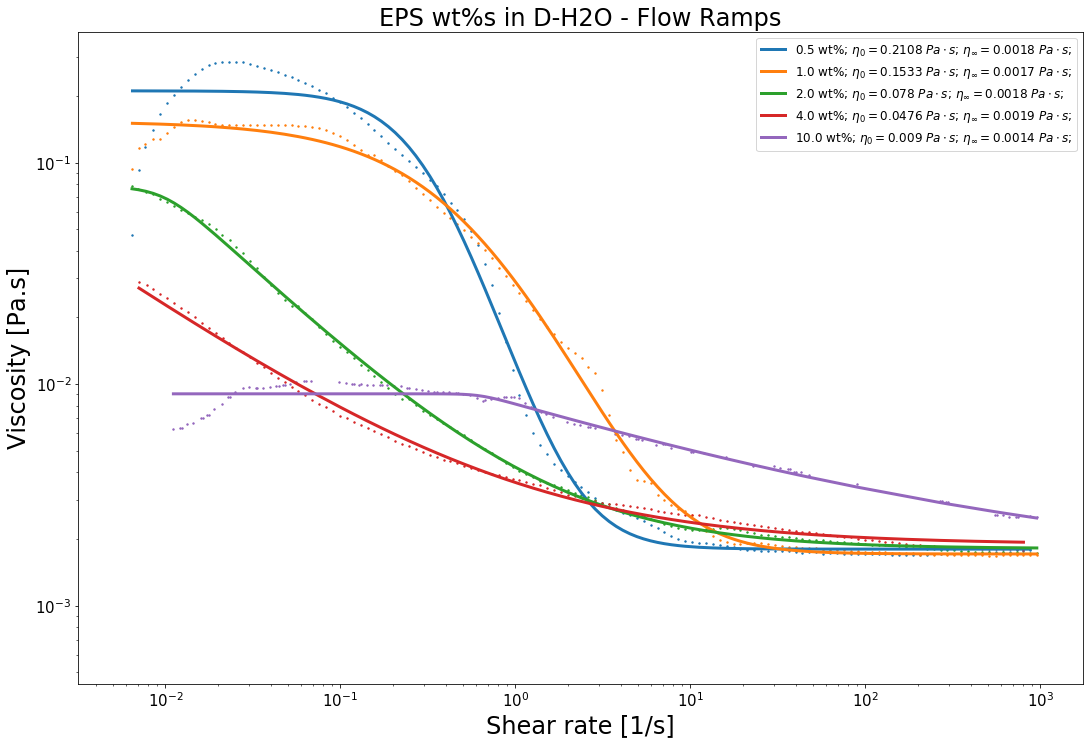

In [10]:
#####
plotName        = "EPS wt%s in D-H2O - Flow Ramps";
fileNames       = ["./esp_0dot5_FR.csv", "./esp_1_FR.csv", "./esp_2_FR.csv", "./esp_4_FR.csv", "./esp_10_FR.csv"];
Model           = [     'CarreauYasuda',  'CarreauYasuda',  'CarreauYasuda',  'CarreauYasuda',   'CarreauYasuda'];
eta_zero        = [            0.210809,         0.153311,        0.0780457,        0.0475666,        0.00904121];
eta_inft        = [          0.00179992,       0.00171121,       0.00180719,       0.00188916,        0.00142419];
kappa           = [             3.28649,          1.39953,          102.388,          420.762,           1.59987];
n               = [            -1.41089,        -0.930191,         0.253781,         0.456235,          0.731301];
m               = [             2.04212,         0.981495,          4.42068,          12.8957,           7.66492];
fileDescription = [           "0.5 wt%",        "1.0 wt%",        "2.0 wt%",        "4.0 wt%",        "10.0 wt%"];
headDrops       = [                   0,                0,                0,                0,                 0];
tailDrops       = [                   0,                0,                0,                0,                 0];
plotDatapoints  = [                True,             True,             True,             True,              True];
plotModel       = [                True,             True,             True,             True,              True];

# Plot all files in one plot
compareData_wFits_(1, 2, True, True, plotName, fileNames, headDrops, tailDrops, fileDescription, Model, eta_zero, eta_inft, kappa, n, m, plotDatapoints, plotModel);

13
Stress             Pa
Shear rate        1/s
Viscosity        Pa.s
Step time           s
Temperature        °C
Normal stress      Pa
Modulus            Pa
Name: 14, dtype: object

<module 'matplotlib.pyplot' from 'C:\\Users\\oskat\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

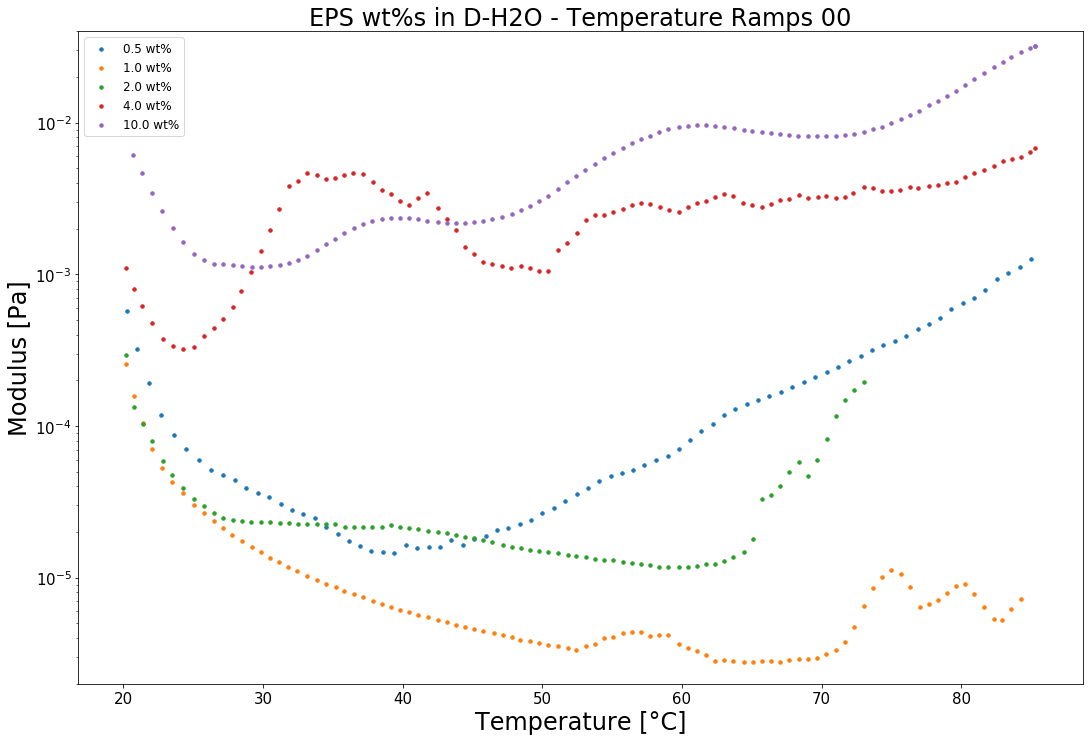

In [11]:
#####
plotName        = "EPS wt%s in D-H2O - Temperature Ramps 00";
fileNames       = ["./esp_0dot5_TR.csv", "./esp_1_TR.csv", "./esp_2_TR.csv", "./esp_4_TR.csv", "./esp_10_TR.csv"];
plotModel       = [               False,            False,            False,            False,             False];

# Plot all files in one plot

compareData_wFits_(4, 6, False, True, plotName, fileNames, headDrops, tailDrops, fileDescription, Model, eta_zero, eta_inft, kappa, n, m, plotDatapoints, plotModel);
plt.ylim(0.000002,0.04); plt.savefig('plt_' + re.sub('[^A-Za-z0-9]+', '', plotName) + '.png', dpi=300, bbox_inches='tight');

13
Stress             Pa
Shear rate        1/s
Viscosity        Pa.s
Step time           s
Temperature        °C
Normal stress      Pa
Modulus            Pa
Name: 14, dtype: object

<module 'matplotlib.pyplot' from 'C:\\Users\\oskat\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

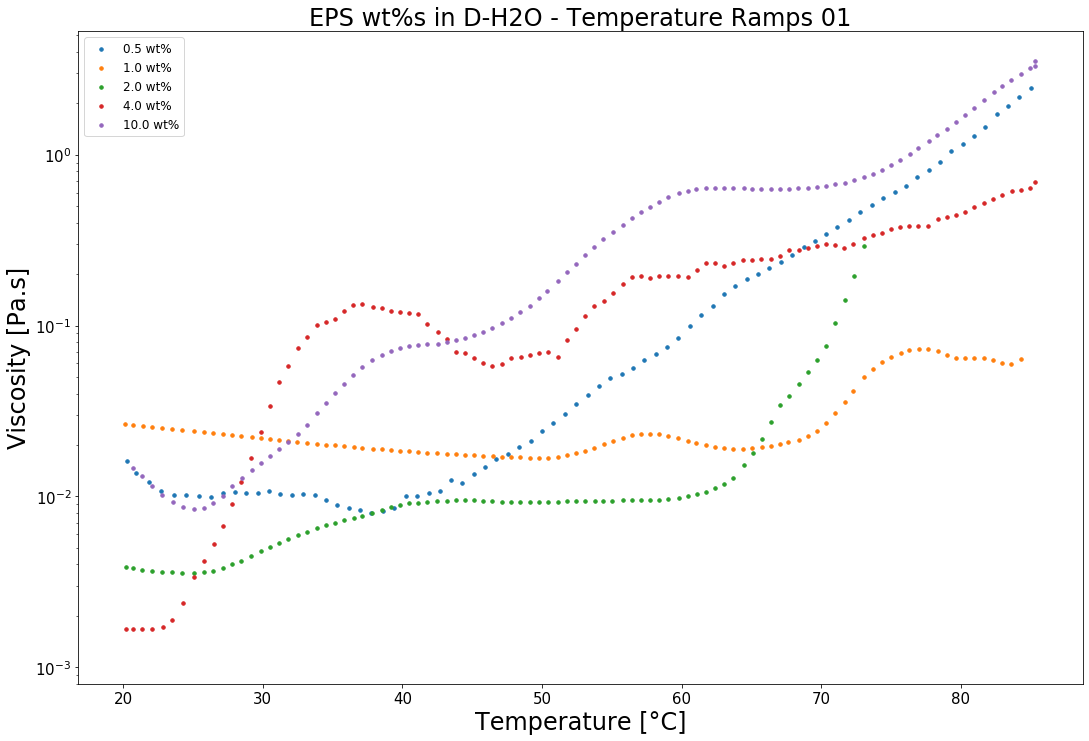

In [12]:
#####
plotName        = "EPS wt%s in D-H2O - Temperature Ramps 01";
fileNames       = ["./esp_0dot5_TR.csv", "./esp_1_TR.csv", "./esp_2_TR.csv", "./esp_4_TR.csv", "./esp_10_TR.csv"];
plotModel       = [               False,            False,            False,            False,             False];

# Plot all files in one plot
compareData_wFits_(4, 2, False, True, plotName, fileNames, headDrops, tailDrops, fileDescription, Model, eta_zero, eta_inft, kappa, n, m, plotDatapoints, plotModel);